# Multicriteria approach to Miller-Orr cash management model

## 1. Loading dataset of cash flows and visualizing some properties

First, we import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

Loading the data set and dividing training and test set

In [2]:
cf=np.loadtxt("datasets/datasets/cash.csv",delimiter=";")
f = np.array(cf,dtype=int)

In [5]:
n = int(0.8*len(f))
f_train = f[:n] 
f_test = f[n:] 
len(f_train),len(f_test)

(800, 200)

In [8]:
mu = np.mean(f_train)
sigma = np.std(f_train)
mu,sigma

(10694.88625, 129146.59506757549)

Plot of the evolution of daily cash flow

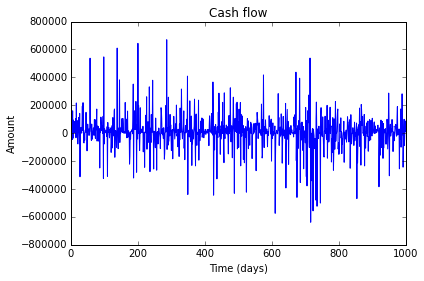

In [9]:
x = np.linspace(1,1000,num=1000)
plt.plot(x, f, label="Cash flow")
plt.xlabel("Time (days)")
plt.ylabel("Amount")
plt.title("Cash flow")

Histogram and best fit normal

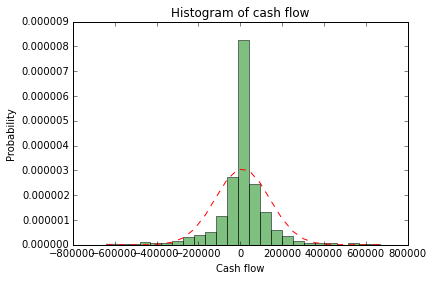

In [10]:
num_bins = 25
n, bins, patches = plt.hist(f, num_bins, normed=1, facecolor='green', alpha=0.5)
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Cash flow')
plt.ylabel('Probability')
plt.title(r'Histogram of cash flow')

## 2. Definition of the class policy

Here we construct the class policy defined by its particular cost structure summarized as: 

$v$: the holding cost per money unit of a positive cash balance at the end of the day; 

$u$: the shortage cost per money unit of a negative cash balance at the end oh the day, 

$\gamma_{0}^{+}$: the fixed cost of transfer into account; 

$\gamma_{0}^{-}$: the fixed cost of transfer from account; 

$\gamma_{1}^{+}$: the variable cost of transfer into account; 

$\gamma_{1}^{-}$: the variable cost of transfer from account. 


A policy in the Miller-Orr cash management model is characterized by a set of bounds or control limits $\{h,z,l\}$ that determines the transfer to be done. 

In [13]:
class policy(object):
    
    def __init__(self,gzeropos,gzeroneg,gonepos,goneneg,v,u,h,z,l):
        self.gzeropos = gzeropos
        self.gzeroneg = gzeroneg
        self.gonepos = gonepos
        self.goneneg = goneneg
        self.v = v
        self.u = u
        self.h = h
        self.z = z
        self.l = l
        self.daily_cost = []
        self.cost_list =[]
        
    def transfer(self,ob):
        """Determines transfer x from parameters, opening balance (ob) and high, z, low"""
        if ob > self.h:
            x = self.z-ob
        elif ob < self.l:
            x = self.z-ob
        else:
            x = 0
        return x
    
    def trans_cost(self,x):
        """Computes the cost of transfer x"""
        cost = 0
        if x<0:
            cost = self.gzeroneg-self.goneneg*x
        elif x>0:
            cost = self.gzeropos+self.gonepos*x
        return cost
    
    def holding_cost(self,final):
        """Computes the holding cost"""
        cost = 0
        if final>=0:
            cost = self.v*final
        else: 
            cost = -self.u*final
        return cost
                
    def cost_calc(self,cf,ob):
        """Computes a vector of daily cost of cash flows and an opening balance"""
        inibal = ob
        bal = ob
        if len(self.daily_cost)>0:
            del self.daily_cost[:]
        for element in cf:
            trans = self.transfer(inibal)
            bal = inibal+trans+element
            self.daily_cost.append(self.trans_cost(trans)+self.holding_cost(bal))
            inibal = bal
        return self.daily_cost
    
    def cost_std(self,daily_cost):
        """Computes std dev of daily cost"""
        #Check that before using this function daily_cost
        return np.std(np.array(daily_cost,dtype=float))
    
    def cost_var(self,daily_cost):
        """Computes variance of daily cost"""
        #Check that before using this function daily_cost
        return st.pvariance(np.array(daily_cost,dtype=float))
    
    def up_dev(self,daily_cost,target):
        """Computes upside std dev above a given target of daily cost"""    
        dc =np.array(daily_cost)
        subset = dc[dc[:] > target]
        length = len(daily_cost)
        result = np.sqrt(np.sum((subset-target)**2/length))
        return result
    
    def space(self,vh,vz,vl,cf,method):
        """Returns a list of daily_cost vectors from the combination of feasible h,z,l"""
        method_name = str(method)
        space={}
        n = 0
        for i in vh:
            for j in vz:
                for k in vl:
                    if (i>=j and j>=k):
                        n = n + 1
                        self.h = i
                        self.z = j
                        self.l = k
                        space[n]=[i,j,k,np.mean(self.cost_calc(cf,self.z)),self.risk_method(method_name,self.daily_cost)]
        return space
    
    def space_up_dev(self,vh,vz,vl,cf,target):
        """Returns a list of daily_cost vectors from the combination of feasible h,z,l"""
        space={}
        n = 0
        for i in vh:
            for j in vz:
                for k in vl:
                    if (i>=j and j>=k):
                        n = n + 1
                        self.h = i
                        self.z = j
                        self.l = k
                        space[n]=[i,j,k,np.mean(self.cost_calc(cf,self.z)),self.up_dev(self.daily_cost,target)]
        return space
    
    def risk_method(self, argument, daily_cost):
        """Dispatch method for selcting cost_std or cost_var"""
        method_name = str(argument)
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, method_name, lambda: "nothing")
        # Call the method as we return it
        return method(daily_cost)


We can initialize an object pol of the class policy with a particular cost structure and $h = 100000$, $z = 50000$ and $l = 25000$

In [14]:
pol = policy(100,5,0.05,0.001,0.00027,0.3,100000,50000,25000)

Then if the initial balance is 125000 the transfer is the amount necessary to reach the targe level that is -75000 with cost 80

In [15]:
pol.transfer(125000)

-75000

In [16]:
pol.trans_cost(-75000)

80.0

Average daily cost over the entire data set with initial balance the target z is:

In [19]:
pol.cost_calc(f,pol.z)
np.mean(pol.daily_cost)

7480.6350171600006

## 3. Deriving the efficient frontier

First we initialize an instance of the class policy with arbitrary $h,z,l$ values, for example, optimal values from Miller-Orr model

In [21]:
gzeropos = 5
v = 0.00027
l_miller = np.std(f_train)*2
z_miller = l_miller+((3*gzeropos*np.std(f_train)**2)/(4*v))**(0.333333)
h_miller = 3*z_miller-2*l_miller
h_miller,z_miller,l_miller

(442537.58082518424, 319707.98703182873, 258293.19013515097)

In [26]:
pol_miller = policy(50,5,0.1,0.001,0.00027,0.3,h_miller,z_miller,l_miller)

In [27]:
np.mean(pol_miller.cost_calc(f_test,z_miller)),np.std(pol_miller.cost_calc(f_test,z_miller))

(2641.4121707881218, 6885.6872754047972)

In [28]:
x_miller =np.mean(pol_miller.cost_calc(f_train,z_miller))
y_miller =np.std(pol_miller.cost_calc(f_train,z_miller))
x_miller,y_miller

(3338.7059763075904, 9500.3402519796746)

Here we define two functions to transform a dict in an array and to derive the efficient frontier

In [25]:
def transform(d):
    """Transforms a dictionary in an array"""
    S = np.zeros((len(d),5))
    for i in range(len(d)):
        S[i,:]=d[i+1][:]
    return S

def frontier(S,col):
    """Accepts a list of policies in increasing order of cost and returns the efficient frontier"""
    P=[]
    i = 0
    P.append(S[i])
    j = 1
    while j<len(S):
        if S[j][col]< S[i][col]:
            i=j
            P.append(S[j])
        j = j+1 
    return np.array(P)

Now we define the limits to search for better policies and create the ranges

In [29]:
sigma1 = np.std(f_train)
sigma2 = 3*np.std(f_train)
h_ini = int(np.round(h_miller-sigma1,-4))
h_end = int(np.round(h_miller+sigma2,-4))
z_ini = int(np.round(z_miller-sigma1,-4))
z_end = int(np.round(z_miller+sigma2,-4))
l_ini = int(np.round(l_miller-sigma1,-4))
l_end = int(np.round(l_miller+sigma2,-4))
h_ini,h_end,z_ini,z_end,l_ini,l_end

(310000, 830000, 190000, 710000, 130000, 650000)

In [30]:
vh = range(h_ini,h_end,10000)
vz = range(z_ini,z_end,10000)
vl = range(l_ini,l_end,10000)
len(vh)*len(vz)*len(vl)

140608

Function space produce a complete search over the input space formed by vh, vz y vl. Here we use standar deviation as a measure of risk

In [31]:
pol = policy(50,5,0.05,0.001,0.00027,0.3,h_miller,z_miller,l_miller)
sp = pol.space(vh,vz,vl,f_train,'cost_std')


A the efficient frontier is stored in P

In [32]:
spa = transform(sp)
S = spa[np.argsort(spa[:,3])]
P = frontier(S,col=4)
len(P)

15

Cost index $\theta_1$ and risk index $\theta_2$ are computed

In [34]:
MaxCost = np.max(P[:,3])
MinCost = np.min(P[:,3])
MaxRisk = np.max(P[:,4])
MinRisk = np.min(P[:,4])
MinCost,MaxCost,MinRisk,MaxRisk

(754.01176111249993, 1226.5445175, 3312.9392483749189, 4050.2542982082164)

Here we plot the efficient frontier in the space C-R and the values obtained from Miller-Orr optimal values for comparison

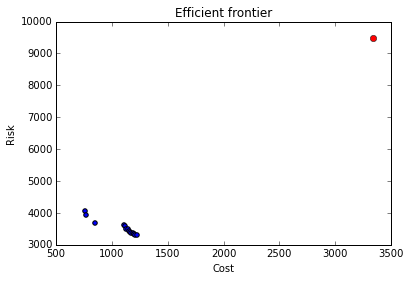

In [36]:
plt.scatter(P[:,3],P[:,4])
plt.plot(x_miller,y_miller,'ro')
plt.xlabel('Cost')
plt.ylabel('Risk')
plt.title(r'Efficient frontier')
plt.show()

Now in the normalized space $\theta_1$-$\theta_2$

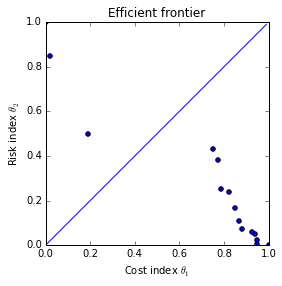

In [37]:
theta1 = (P[:,3]-MinCost)/(MaxCost-MinCost)
theta2 = (P[:,4]-MinRisk)/(MaxRisk-MinRisk)
x_line,y_line = 0.01*np.array(range(0,100,1)),0.01*np.array(range(0,100,1))
plt.scatter(theta1,theta2)
plt.axis([0,1,0,1])
plt.plot(x_line, y_line)
plt.xlabel('Cost index $\\theta_1$')
plt.ylabel('Risk index $\\theta_2$')
plt.title(r'Efficient frontier')
plt.axes().set_aspect('equal')
#plt.savefig('EF.pdf')

A new data array is formed with $\theta_1$ and $\theta_2$ to store results

In [40]:
new_col1 = theta1[...,None]
new_col2 = theta2[...,None]
PA = np.concatenate((P, new_col1, new_col2), 1)
#np.savetxt('MillerTable.txt',PA,fmt='%.2f',delimiter =';')

The best policy minimizes distance to the ideal point $(0,0)$

In [41]:
def find_policy(P,col1=5,col2=6):
    """Find the policy tha minimizes distance to the ideal in the space col1-col2"""
    min_dist = 1
    best = P[0,:]
    for element in range(len(P)):
        dist = np.sqrt(P[element,col1]**2+P[element,col2]**2)
        if dist < min_dist:
            best = P[element,:]
            min_dist = dist
    return best

In [42]:
best = find_policy(PA)
print(best)

[  8.20000000e+05   5.30000000e+05   2.30000000e+05   8.44900947e+02
   3.67882650e+03   1.92344732e-01   4.96242761e-01]


Evaluate the best policy over the test set and the training set

In [43]:
test = policy(50,5,0.05,0.001,0.00027,0.3,best[0],best[1],best[2])

In [44]:
np.mean(test.cost_calc(f_test,best[1])),np.std(test.cost_calc(f_test,best[1]))

(652.30655200000012, 3067.421072463615)

In [45]:
np.mean(test.cost_calc(f_train,best[1])),np.std(test.cost_calc(f_train,best[1]))

(844.9009473750001, 3678.8265045417697)

## 3. Considering the test set error as a new measure of risk

Minimizing cost-risk square error and cost-risk understimation

### 3.1 Cost-risk square error

First we search for feasible policies in the training set and the test set. Again, initilization of $h,z,l$ is arbitrary

In [46]:
pol = policy(50,5,0.05,0.01,0.00027,0.3,h_miller,z_miller,l_miller)

In [47]:
sp1 = pol.space(vh,vz,vl,f_train,'cost_std')
sp2 = pol.space(vh,vz,vl,f_test,'cost_std')

In [49]:
S1 = transform(sp1)
S2 = transform(sp2)
   

$\theta_1$ and $\theta_2$ are obtained for the training set and the test set

In [50]:
MaxCost1 = np.max(S1[:,3])
MinCost1 = np.min(S1[:,3])
MaxRisk1 = np.max(S1[:,4])
MinRisk1 = np.min(S1[:,4])
MaxCost2 = np.max(S2[:,3])
MinCost2 = np.min(S2[:,3])
MaxRisk2 = np.max(S2[:,4])
MinRisk2 = np.min(S2[:,4])
MinCost1,MaxCost1,MinCost2,MaxCost2

(939.08371201250009,
 3593.3192204624997,
 516.48381760000007,
 2508.8660864000003)

In [51]:
train_theta1 = (S1[:,3]-MinCost1)/(MaxCost1-MinCost1)
train_theta2 = (S1[:,4]-MinRisk1)/(MaxRisk1-MinRisk1)
test_theta1 = (S2[:,3]-MinCost2)/(MaxCost2-MinCost2)
test_theta2 = (S2[:,4]-MinRisk2)/(MaxRisk2-MinRisk2)

And now we obtain $\theta_3$ as the normalized distance between predicted points ($\theta_1^*,\theta_2^*$) from the training set and real points ($\theta_1,\theta_2$) from the test set

In [54]:
Dist = np.sqrt((train_theta1-test_theta1)**2+(train_theta2-test_theta2)**2)
MaxDist = np.max(Dist)
MinDist = np.min(Dist)
theta3 = (Dist - MinDist)/(MaxDist-MinDist)
MaxDist,MinDist,np.max(theta3)

(0.80903436572271636, 0.0011035970604048393, 1.0)

$\theta_3$ is added to the initial C-R space and a new efficient frontier is obtained in the space Cost-Error

In [79]:
new_col3 = theta3[...,None]
S = np.concatenate((S1, new_col3), 1)
P2=frontier(S[np.argsort(S[:,3])],col=5)

In [80]:
new_theta1 = (P2[:,3]-np.min(P2[:,3]))/(np.max(P2[:,3])-np.min(P2[:,3]))
new_theta3 = (P2[:,5]-np.min(P2[:,5]))/(np.max(P2[:,5])-np.min(P2[:,5]))
col1=new_theta1[...,None]
col3=new_theta3[...,None]
PA = np.concatenate((P2, col1, col3), 1)
np.savetxt('MillerTable.txt',PA,fmt='%.2f',delimiter =';')

We find the most robust policy to prediction errors as the policy closer to the ideal point

In [81]:
best2=find_policy(PA,col1=6,col2=7)
best2

array([  8.20000000e+05,   5.40000000e+05,   1.60000000e+05,
         1.01215038e+03,   4.70321518e+03,   2.84824488e-02,
         1.28074870e-01,   1.21949126e-01])

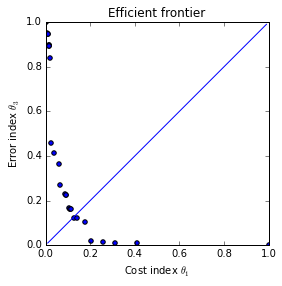

In [70]:
x_line,y_line = 0.01*np.array(range(1,100,1)),0.01*np.array(range(1,100,1))
plt.scatter(new_theta1,new_theta3)
plt.plot(x_line, y_line)
plt.axis([0,1,0,1])
plt.xlabel('Cost index $\\theta_1$')
plt.ylabel('Error index $\\theta_3$')
plt.title(r'Efficient frontier')
plt.axes().set_aspect('equal')
plt.savefig('EF.pdf')

In [82]:
test2 = policy(50,5,0.05,0.001,0.00027,0.3,best2[0],best2[1],best2[2])

In [83]:
a = np.mean(test.cost_calc(f_test,best[1])),np.std(test.cost_calc(f_test,best[1]))
b = np.mean(test2.cost_calc(f_test,best2[1])),np.std(test2.cost_calc(f_test,best2[1]))
a,b

((652.30655200000012, 3067.421072463615),
 (475.81300040000002, 2734.1533723922753))

### 3.1 Cost-risk under estimation

Cost-risk underestimation, real(test)-pred(train) Manhattan distance, we can use weights for risk preferences

In [131]:
Man_Dist = (train_theta1-test_theta1)+(train_theta2-test_theta2)
MaxDist = np.max(Man_Dist)
MinDist = np.min(Man_Dist)
theta3U = (Man_Dist - MinDist)/(MaxDist-MinDist)
MaxDist,MinDist

(1.1216362176267416, -0.60402388820089636)

In [132]:
new_col3 = theta3U[...,None]
SU = np.concatenate((S1, new_col1, new_col2, new_col3), 1)
P2U=frontier(SU[np.argsort(SU[:,5])],col=7)
best2U=find_policy(P2U,col1=5,col2=7)
best2U

array([  7.30000000e+05,   5.10000000e+05,   1.30000000e+05,
         1.01862009e+03,   4.92593692e+03,   2.99658315e-02,
         1.81584203e-01,   1.11063806e-02])

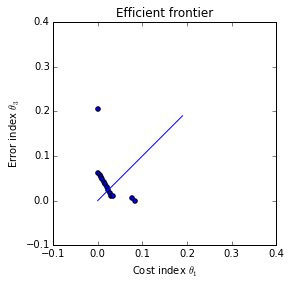

In [133]:
x_line,y_line = 0.01*np.array(range(0,20,1)),0.01*np.array(range(0,20,1))
plt.scatter(P2U[:,5],P2U[:,7])
plt.plot(x_line, y_line)
plt.axis([-0.1,0.4,-0.1,0.4])
plt.xlabel('Cost index $\\theta_1$')
plt.ylabel('Error index $\\theta_3$')
plt.title(r'Efficient frontier')
plt.axes().set_aspect('equal')
plt.show()

In [134]:
test2U = policy(100,5,0.05,0.001,0.00027,0.3,best2U[0],best2U[1],best2U[2])
a = np.mean(test.cost_calc(f_test,best[1])),np.std(test.cost_calc(f_test,best[1]))
b = np.mean(test2.cost_calc(f_test,best2[1])),np.std(test2.cost_calc(f_test,best2[1]))
c = np.mean(test2U.cost_calc(f_test,best2U[1])),np.std(test2U.cost_calc(f_test,best2U[1]))
a,b,c

((708.44105390000016, 3332.536183964849),
 (476.56300040000002, 2740.2201476429686),
 (943.54962525000008, 4940.2050685173981))

Cost risk-under estimation does not produce better results
